In [1]:
import pathlib as pl
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
import numpy as np 
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import pathlib as pl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import seaborn as sns
from copy import deepcopy

from sklearn.metrics import mutual_info_score 

### dice

In [2]:
def dice_coef(truth, pred, smooth=1):
    
    true_flat = tf.reshape(truth, [-1])
    pred_flat = tf.reshape(pred, [-1])
    
    intersection = tf.reduce_sum(true_flat*pred_flat)
    return ((2. * intersection)+smooth) / (tf.reduce_sum(true_flat)+tf.reduce_sum(pred_flat) + smooth)


def dice_coef_loss(gt, pred):
    return 1-dice_coef(gt, pred)

# model

In [3]:
shrink = 8

In [4]:
def unet(pretrained_weights = None,input_size = (240,240,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss =dice_coef_loss, metrics = [dice_coef])

    return model


In [5]:
bad = unet()

In [6]:
good = unet()

# get paths to weights

In [7]:
f_dir = pl.Path.cwd().parent.parent.parent.parent.parent.parent \
        / "nfs" / "masi" / "remedilw" / "class" / "vis" /"vis_proj"/"weights"
f_dir

PosixPath('/nfs/masi/remedilw/class/vis/vis_proj/weights')

In [8]:
bad_w = f_dir/'weights00000200.h5'
good_w = f_dir/"weights00001000.h5"

# load weights

In [9]:
bad.load_weights(bad_w)

In [10]:
good.load_weights(good_w)

# visualize weights

In [11]:
len( bad.get_weights() )

48

# 48 layers, but every other layer is BIAS

In [12]:
for i in range(0, 48, 2):
    
    print( bad.get_weights()[i].shape )
    print( bad.get_weights()[i+1].shape )    
    
    print()

(3, 3, 1, 8)
(8,)

(3, 3, 8, 8)
(8,)

(3, 3, 8, 16)
(16,)

(3, 3, 16, 16)
(16,)

(3, 3, 16, 32)
(32,)

(3, 3, 32, 32)
(32,)

(3, 3, 32, 64)
(64,)

(3, 3, 64, 64)
(64,)

(3, 3, 64, 128)
(128,)

(3, 3, 128, 128)
(128,)

(2, 2, 128, 64)
(64,)

(3, 3, 128, 64)
(64,)

(3, 3, 64, 64)
(64,)

(2, 2, 64, 32)
(32,)

(3, 3, 64, 32)
(32,)

(3, 3, 32, 32)
(32,)

(2, 2, 32, 16)
(16,)

(3, 3, 32, 16)
(16,)

(3, 3, 16, 16)
(16,)

(2, 2, 16, 8)
(8,)

(3, 3, 16, 8)
(8,)

(3, 3, 8, 8)
(8,)

(3, 3, 8, 2)
(2,)

(1, 1, 2, 1)
(1,)



In [13]:
for i in range(0, 48, 2):
    
    print( good.get_weights()[i].shape )
    print( good.get_weights()[i+1].shape )    
    
    print()

(3, 3, 1, 8)
(8,)

(3, 3, 8, 8)
(8,)

(3, 3, 8, 16)
(16,)

(3, 3, 16, 16)
(16,)

(3, 3, 16, 32)
(32,)

(3, 3, 32, 32)
(32,)

(3, 3, 32, 64)
(64,)

(3, 3, 64, 64)
(64,)

(3, 3, 64, 128)
(128,)

(3, 3, 128, 128)
(128,)

(2, 2, 128, 64)
(64,)

(3, 3, 128, 64)
(64,)

(3, 3, 64, 64)
(64,)

(2, 2, 64, 32)
(32,)

(3, 3, 64, 32)
(32,)

(3, 3, 32, 32)
(32,)

(2, 2, 32, 16)
(16,)

(3, 3, 32, 16)
(16,)

(3, 3, 16, 16)
(16,)

(2, 2, 16, 8)
(8,)

(3, 3, 16, 8)
(8,)

(3, 3, 8, 8)
(8,)

(3, 3, 8, 2)
(2,)

(1, 1, 2, 1)
(1,)



# drop biases

#### index list with list of indices

In [14]:
a = ["a", "b", "c", "d", "e"]
b = [x for x in range(5) if x%2 != 0]

In [15]:
b

[1, 3]

In [16]:
[ a[x] for x in b  ]

['b', 'd']

#### drop biases with this technique

In [17]:
gw = good.get_weights()
bw = bad.get_weights()

In [18]:
keep_idx = [x for x in range(48) if x%2 == 0]

In [19]:
gw = [gw[x] for x in keep_idx]

In [20]:
bw = [bw[x] for x in keep_idx]

# see shapes

In [21]:
for f in gw:
    print(f.shape)

(3, 3, 1, 8)
(3, 3, 8, 8)
(3, 3, 8, 16)
(3, 3, 16, 16)
(3, 3, 16, 32)
(3, 3, 32, 32)
(3, 3, 32, 64)
(3, 3, 64, 64)
(3, 3, 64, 128)
(3, 3, 128, 128)
(2, 2, 128, 64)
(3, 3, 128, 64)
(3, 3, 64, 64)
(2, 2, 64, 32)
(3, 3, 64, 32)
(3, 3, 32, 32)
(2, 2, 32, 16)
(3, 3, 32, 16)
(3, 3, 16, 16)
(2, 2, 16, 8)
(3, 3, 16, 8)
(3, 3, 8, 8)
(3, 3, 8, 2)
(1, 1, 2, 1)


# avg over channel dimension 

In [22]:
def dimension_avg(list_of_filters, axis):

    for i in range(len(list_of_filters)):

        list_of_filters[i] = np.mean(list_of_filters[i], axis=axis)

    return list_of_filters
    

# copy before averaging

In [23]:
gw_orig = deepcopy(gw)
bw_orig = deepcopy(bw)

# channel avg

In [24]:
gw = dimension_avg(gw, 2)

In [25]:
bw = dimension_avg(bw, 2)

In [26]:
for f in gw:
    print(f.shape)

(3, 3, 8)
(3, 3, 8)
(3, 3, 16)
(3, 3, 16)
(3, 3, 32)
(3, 3, 32)
(3, 3, 64)
(3, 3, 64)
(3, 3, 128)
(3, 3, 128)
(2, 2, 64)
(3, 3, 64)
(3, 3, 64)
(2, 2, 32)
(3, 3, 32)
(3, 3, 32)
(2, 2, 16)
(3, 3, 16)
(3, 3, 16)
(2, 2, 8)
(3, 3, 8)
(3, 3, 8)
(3, 3, 2)
(1, 1, 1)


In [27]:
for f in bw:
    print(f.shape)

(3, 3, 8)
(3, 3, 8)
(3, 3, 16)
(3, 3, 16)
(3, 3, 32)
(3, 3, 32)
(3, 3, 64)
(3, 3, 64)
(3, 3, 128)
(3, 3, 128)
(2, 2, 64)
(3, 3, 64)
(3, 3, 64)
(2, 2, 32)
(3, 3, 32)
(3, 3, 32)
(2, 2, 16)
(3, 3, 16)
(3, 3, 16)
(2, 2, 8)
(3, 3, 8)
(3, 3, 8)
(3, 3, 2)
(1, 1, 1)


# filter avg

In [28]:
gw = dimension_avg(gw, 2)
bw = dimension_avg(bw, 2)

In [29]:
for f in gw:
    print(f.shape)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(3, 3)
(1, 1)


In [30]:
for f in bw:
    print(f.shape)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(2, 2)
(3, 3)
(3, 3)
(3, 3)
(1, 1)


# visualize now that there are only 24 weights per model

In [31]:
good_f = gw[0]
bad_f = bw[0]

In [32]:
def normalize(filters):

    # if it's a scalar ignore
    if filters.shape == (1,1):
        pass
    
    else:
        filters = deepcopy(filters)

        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
    return filters

# MSE

In [33]:
def MSE(a, b):
    
    mse = tf.keras.losses.MSE(normalize(a).flatten(), 
                                  normalize(b).flatten())


        
    return (np.round(mse.numpy(), 5))
    

In [34]:
plt.rcParams["font.family"] = "serif"


In [35]:
def plot_filters(bw, gw, layer_idx):
    
    bw_min = bw.min()
    gw_min = gw.min()
    f_min = bw_min
    if gw_min < f_min:
        f_min = gw_min
        
    bw_max = bw.max()
    gw_max = gw.max()
    f_max = bw_max
    if gw_max > f_max:
        f_max = gw_max
    
    
    f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                gridspec_kw={'width_ratios':[3,3,0.08]})
    f.set_figwidth(10)
    f.set_figheight(5)

    
    mse = MSE(bw, gw)
    
    
    f.suptitle("MSE "+str(mse), size=20, y=-0.01)
    
    ax1.get_shared_y_axes().join(ax2)

    g1 = sns.heatmap(bw,
                     cmap="gray",
                     vmin=f_min,
                     vmax=f_max,
                     annot=True, 
                     xticklabels=False, 
                     yticklabels=False,
                     cbar=False,
                     ax=ax1)
    g1.set_ylabel('')
    g1.set_xlabel('')
    g1.set_title("Partially Trained")


    g2 = sns.heatmap(gw,
                     cmap="gray",
                     vmin=f_min,
                     vmax=f_max,
                     annot=True, 
                     xticklabels=False, 
                     yticklabels=False,
                     cbar=True,
                     ax=ax2, 
                     cbar_ax=axcb)
    g2.set_ylabel('')
    g2.set_xlabel('')
    g2.set_title("Fully Trained")
    plt.show()
    save_path = pl.Path.cwd() / "filter_plots"
    
    if layer_idx < 10:
        layer_idx = "0" + str(layer_idx)
    else:
        layer_idx = str(layer_idx)
    
    f.savefig(save_path/"{}_layer_filters_plot".format(layer_idx), dpi=600)


# Visualize the filters

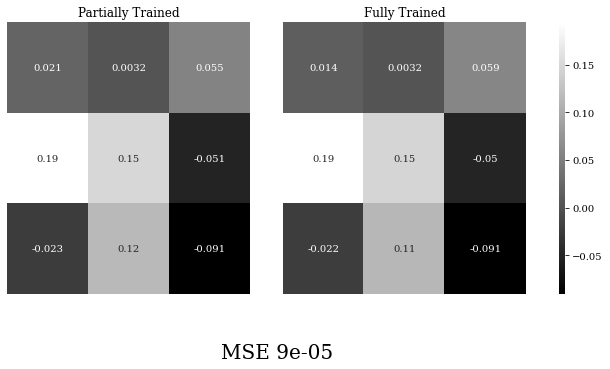

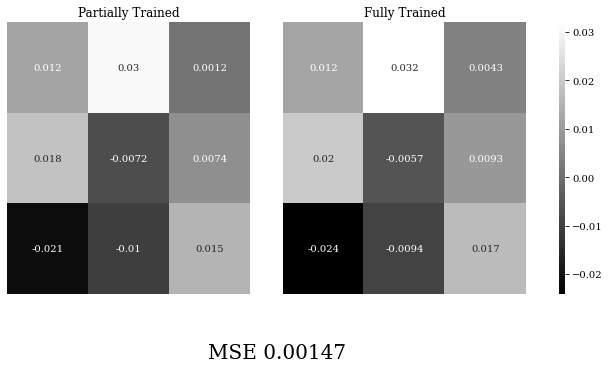

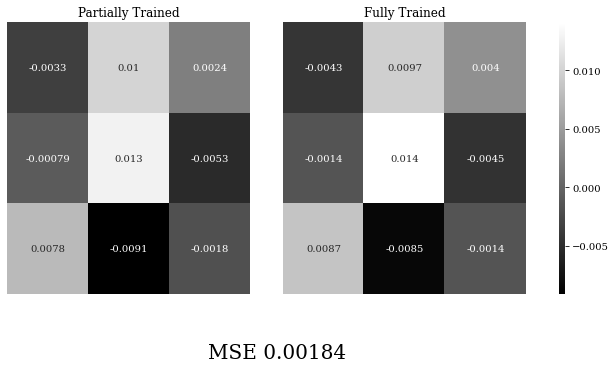

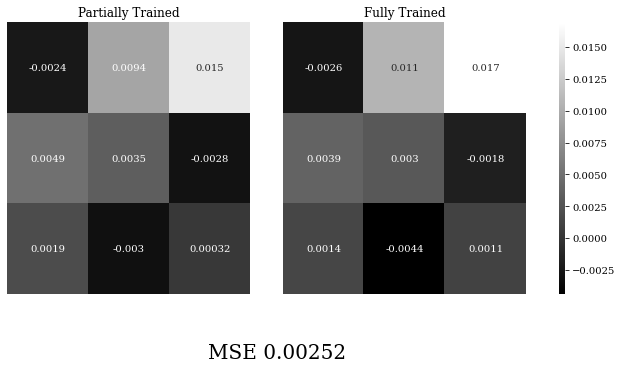

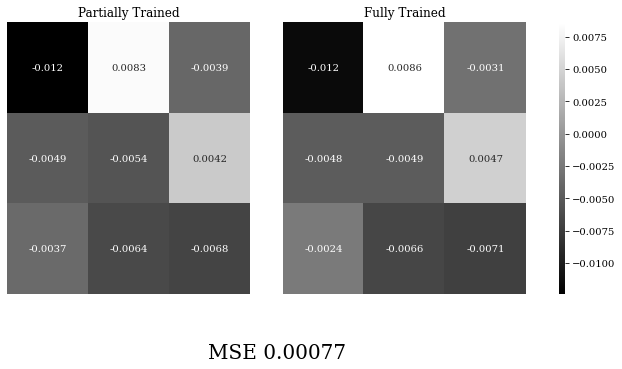

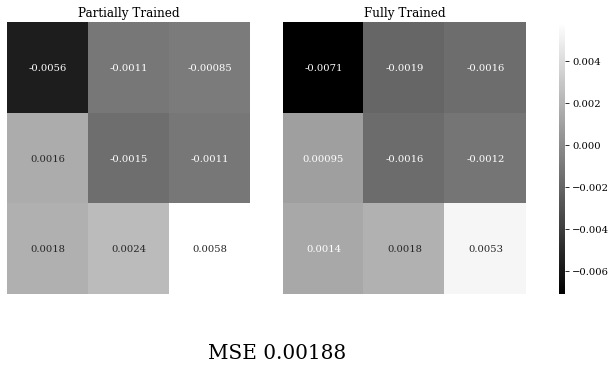

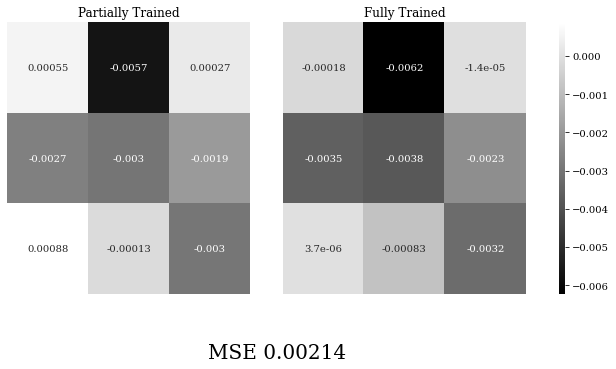

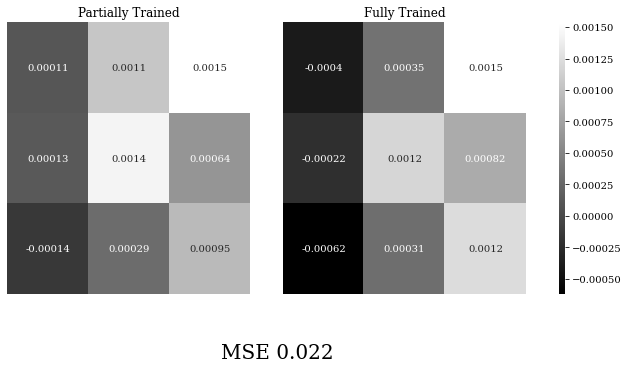

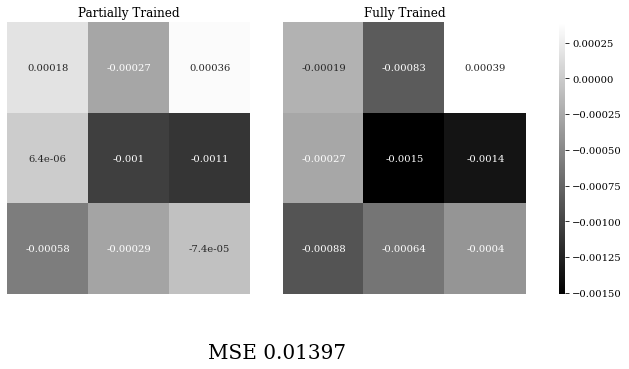

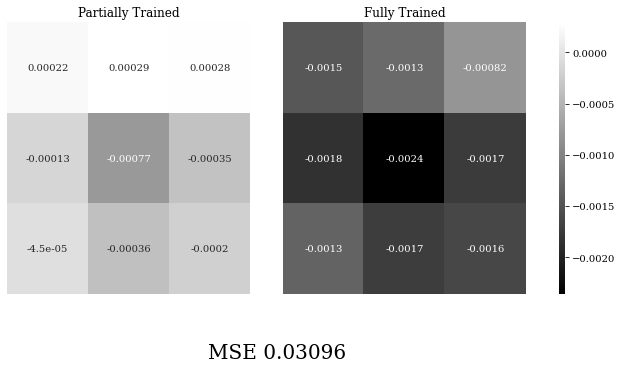

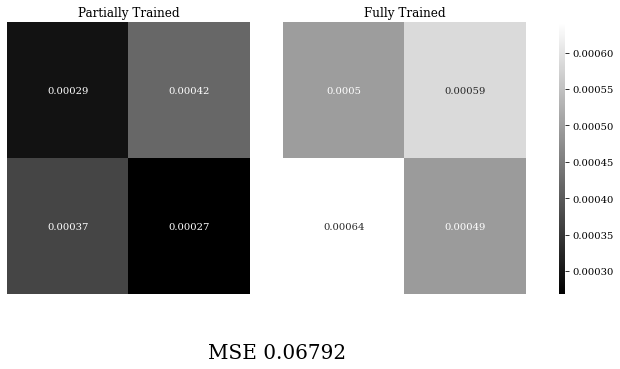

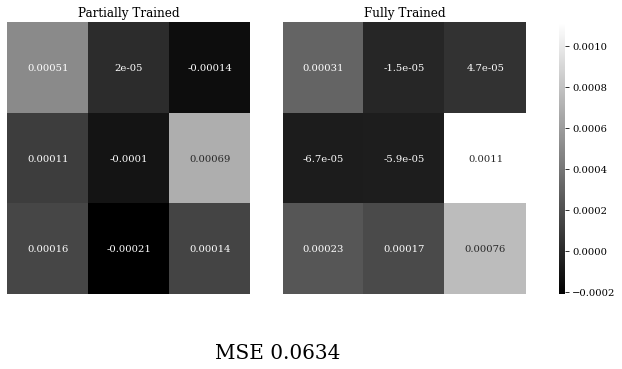

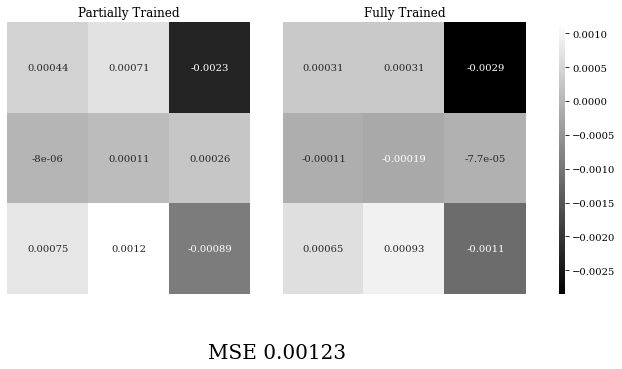

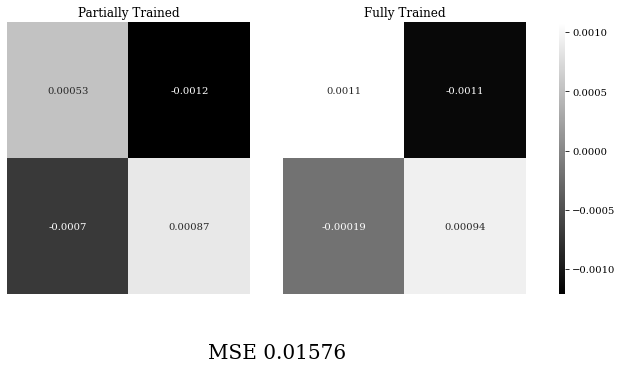

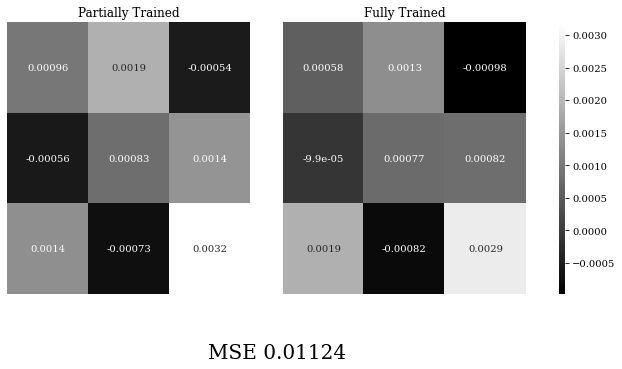

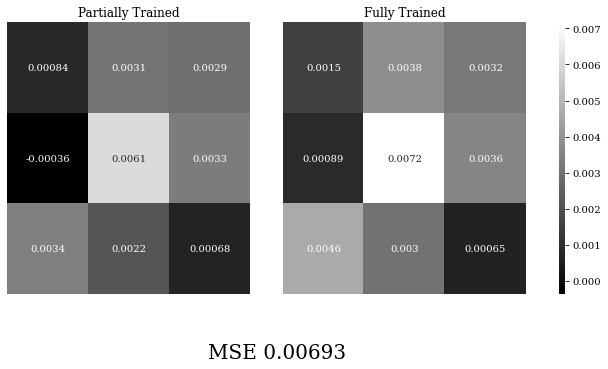

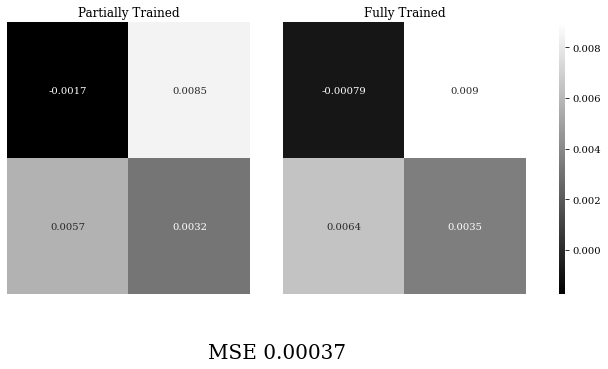

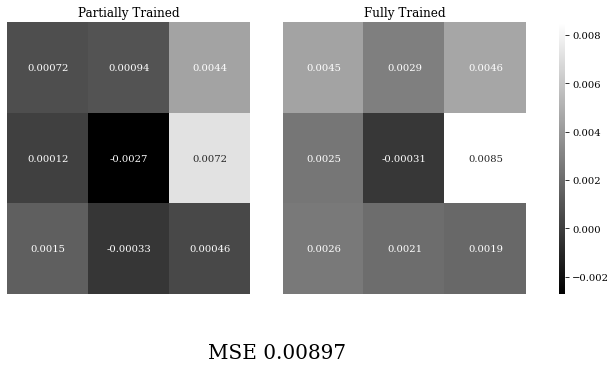

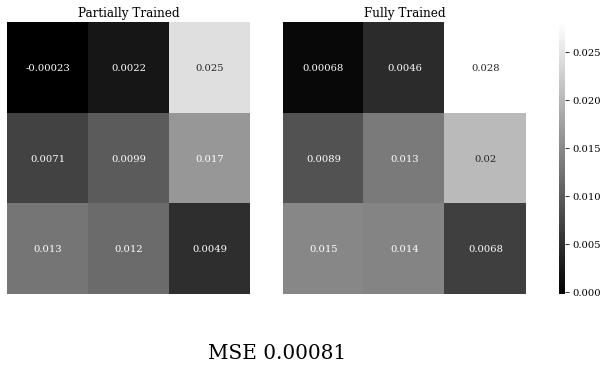

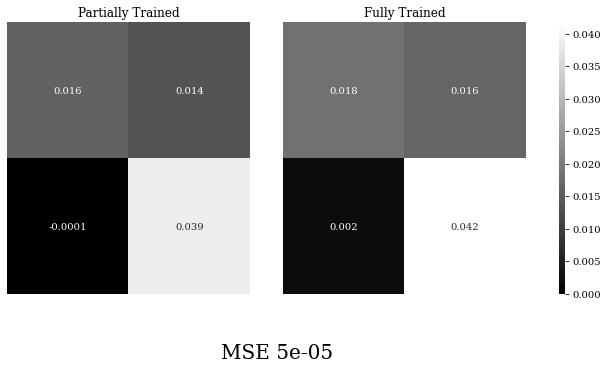

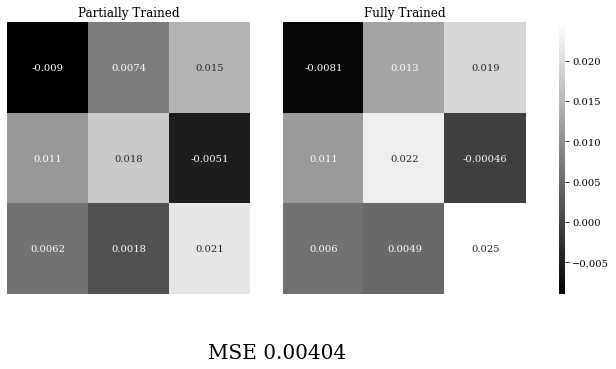

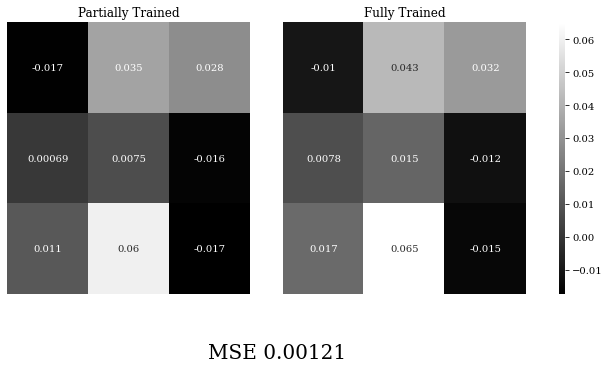

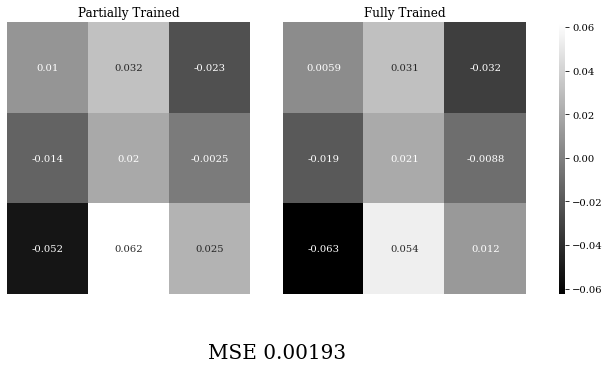

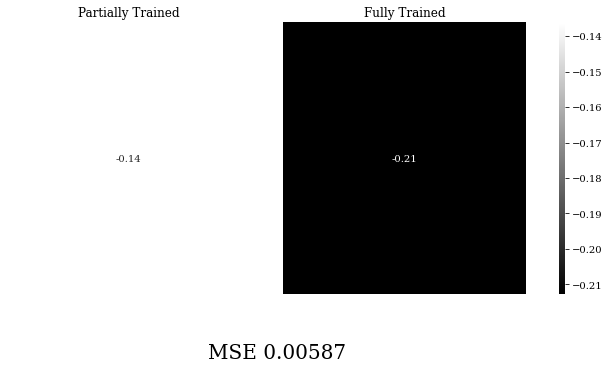

In [36]:
for i in range(len(bw)):
    plot_filters(bw[i], gw[i], i)